### Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install -q funcsigs

In [3]:
import os
import numpy as np
import pandas as pd
import time
# features
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
## models
#from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# save model
from sklearn.externals import joblib
# model testing
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix 
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, brier_score_loss, recall_score, precision_score
from funcsigs import signature
# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Reading Test Data and Model

In [0]:
data_location = os.path.join('drive','My Drive')

In [51]:
# read input data
print("Reading Test Data...")
start = time.time()
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test_scaled.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train_scaled.pkl'))
pure_text_cols = ['source_name','url','created_date','tag','heading','author','article_text', 'preprocessed_text']
X_test=X_test1.loc[:, ~X_test1.columns.isin(pure_text_cols)]
X_train=X_train1.loc[:, ~X_train1.columns.isin(pure_text_cols)]
y_test1 = pd.read_pickle(os.path.join(data_location,'y_test.pkl'))
y_train1 = pd.read_pickle(os.path.join(data_location,'y_train.pkl'))
y_test=y_test1['label'].astype(int)
y_train=y_train1['label'].astype(int)
print('Read Test Data!')
print('Time: ',time.time() - start)

Reading Test Data...
Read Test Data!
Time:  6.440570831298828


## Random Forest Classifier

In [0]:
#model = joblib.load(model_location)
model= RandomForestClassifier(n_estimators=250, max_depth=15)

In [0]:
def get_predictions(model, test):
    # get predictions
    probs = model.predict_proba(test)
    preds = probs[:,1]
    return preds

In [53]:
model.fit(X_train.values, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
def find_cutoff(ground_truth, predictions, metric):
    best_score = 0
    best_cutoff = 0
    for i in np.linspace(0, 1, 101):
        y_pred = (predictions>=i).astype(int)
        score = metric(y_true = ground_truth, y_pred = y_pred)
        if score >= best_score:
            best_cutoff = i
            best_score = score
    return best_cutoff

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

In [0]:
def ml_report(model, y_true, predictions, cutoff = 0.5, top_feats = 10):
    y_pred = (preds>=cutoff).astype(int)
    print("Classification report:\n%s\n"
          % classification_report(y_true, y_pred))
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    
    # print model performance
    print("F1 Score: %.2f" %f1_score(y_true, y_pred))
    print("Recall: %.2f" %recall_score(y_true, y_pred))
    print("Precision: %.2f" %precision_score(y_true, y_pred))
    print("Accuracy: %.2f" %accuracy_score(y_true, y_pred))
    print("Brier Score: %.2f" %brier_score_loss(y_true, y_pred))
    
    # confusion matrix
    plt.subplot(1, 4, 1)
    df_cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred), 
        index=[0, 1], 
        columns=[0, 1], 
    )
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # roc curve
    plt.subplot(1, 4, 2)
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, '#e74c3c', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', color = '#34495e')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    # p-r curve
    plt.subplot(1, 4, 3)
    average_precision = average_precision_score(y_true, preds)
    precision, recall, _ = precision_recall_curve(y_true, preds)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='#e74c3c', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='#e74c3c', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.4f}'.format(
              average_precision))
    plt.show()
    print("\n")
    plt.figure(figsize = (14, 10))
    # feature imp plot
    #feat_imps = model.feature_importances_
    #top_n_feats = np.argsort(feat_imps)[::-1][:top_feats]
    #plt.title('Feature Importance')
    #sns.barplot(x = feat_imps[top_n_feats], y = X_test.columns[top_n_feats])
    #plt.xlabel("Importances")
    #plt.ylabel("Features")
    
    plt.show()

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      3090
           1       0.66      0.75      0.70       353

    accuracy                           0.93      3443
   macro avg       0.81      0.85      0.83      3443
weighted avg       0.94      0.93      0.94      3443


F1 Score: 0.70
Recall: 0.75
Precision: 0.66
Accuracy: 0.93
Brier Score: 0.07


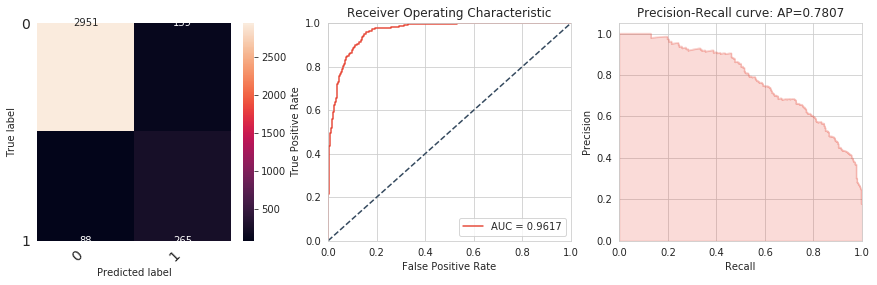

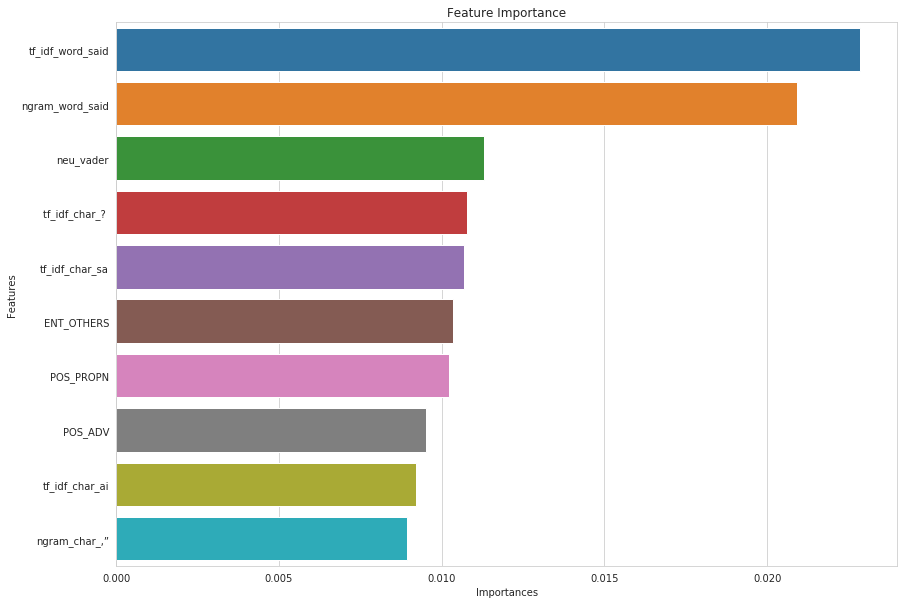

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

## Decision Tree Classifier

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
model=DecisionTreeClassifier(max_depth=6)

In [0]:
model.fit(X_train.values, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      3090
           1       0.46      0.72      0.56       353

    accuracy                           0.88      3443
   macro avg       0.71      0.81      0.75      3443
weighted avg       0.91      0.88      0.89      3443


F1 Score: 0.56
Recall: 0.72
Precision: 0.46
Accuracy: 0.88
Brier Score: 0.12


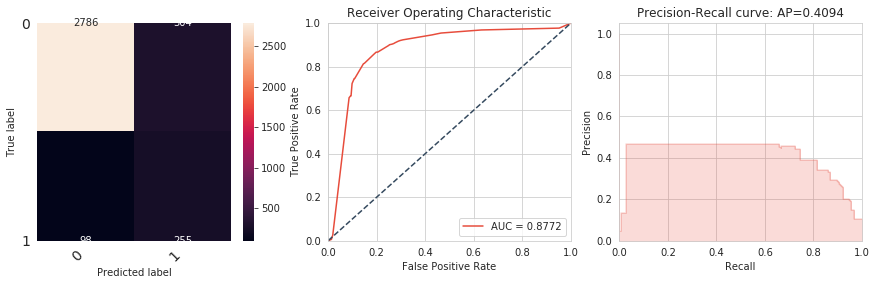

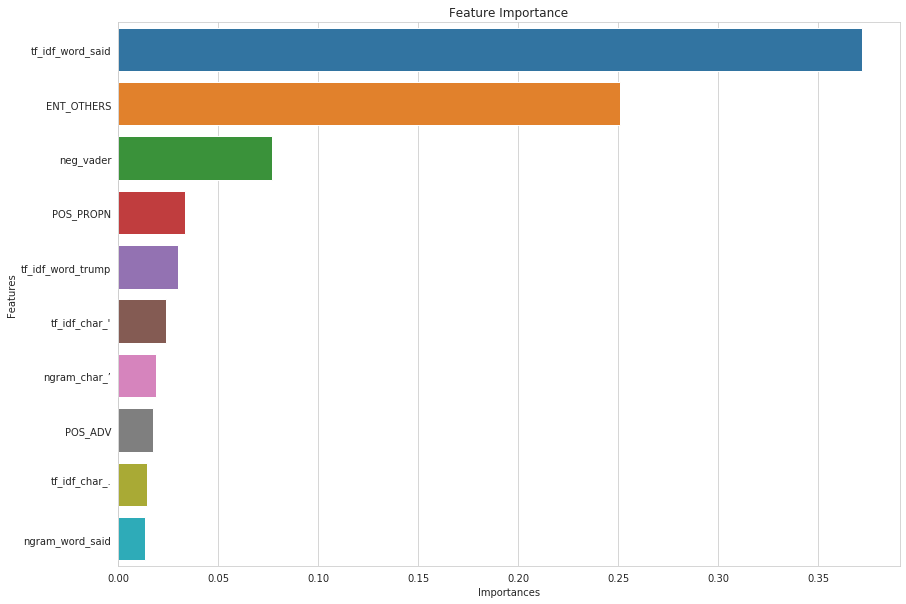

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

## GradientBoost

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [0]:
model= GradientBoostingClassifier(n_estimators=90,learning_rate=0.1, min_samples_split=500,min_samples_leaf=40,max_depth=6,max_features=10,subsample=0.8,random_state=10)

In [0]:
model.fit(X_train.values, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=10, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=40, min_samples_split=500,
                           min_weight_fraction_leaf=0.0, n_estimators=90,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3090
           1       0.63      0.73      0.68       353

    accuracy                           0.93      3443
   macro avg       0.80      0.84      0.82      3443
weighted avg       0.93      0.93      0.93      3443


F1 Score: 0.68
Recall: 0.73
Precision: 0.63
Accuracy: 0.93
Brier Score: 0.07


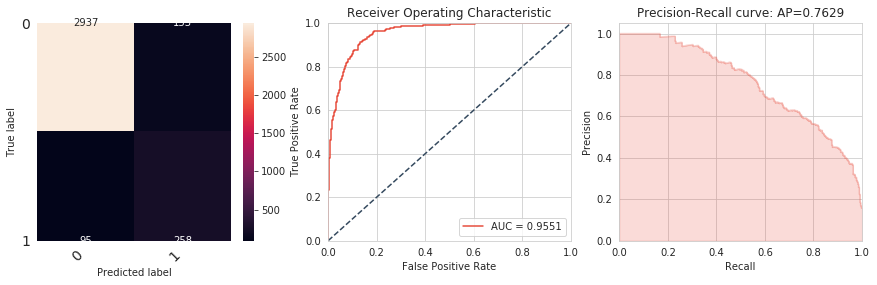

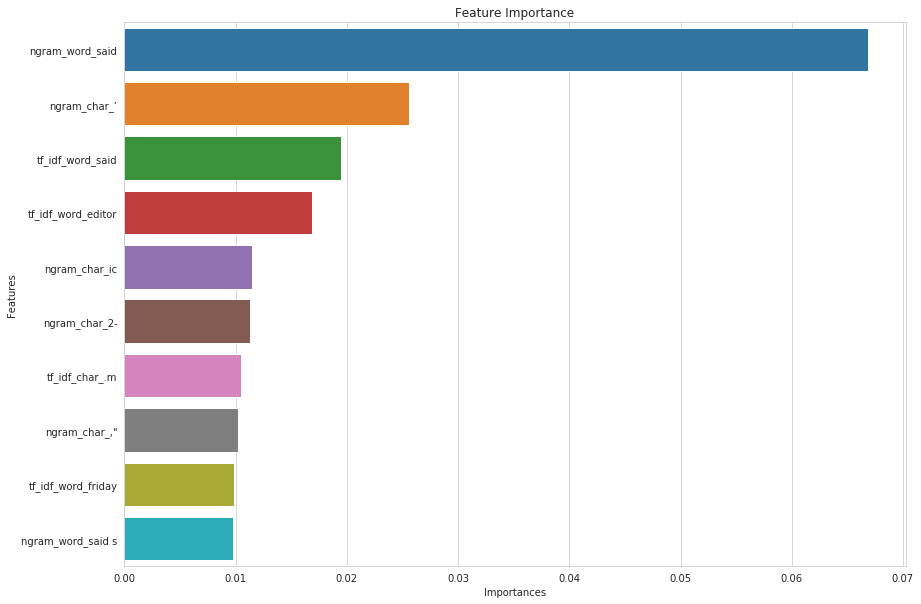

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

## Logistic Regression 

In [0]:
from sklearn.linear_model import LogisticRegression

In [0]:
model= LogisticRegression(C=0.1,penalty='l1')

In [0]:
model.fit(X_train.values, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3090
           1       0.70      0.79      0.74       353

    accuracy                           0.94      3443
   macro avg       0.84      0.88      0.86      3443
weighted avg       0.95      0.94      0.95      3443


F1 Score: 0.74
Recall: 0.79
Precision: 0.70
Accuracy: 0.94
Brier Score: 0.06


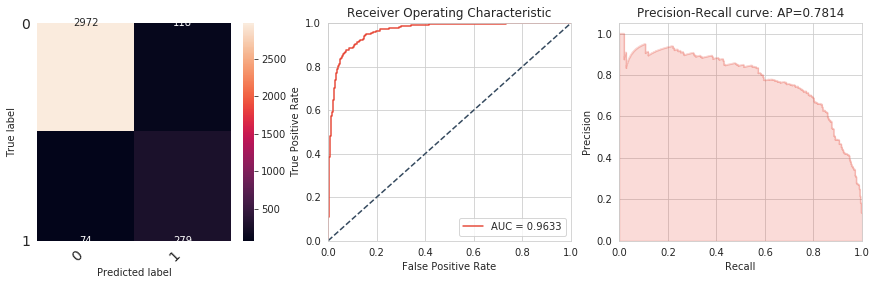

AttributeError: ignored

<Figure size 1008x720 with 0 Axes>

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

Logistic regression- first 200 words

In [0]:
model= LogisticRegression(C=0.001,penalty='l2')

In [0]:
model.fit(X_train.values, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89      3090
           1       0.31      0.63      0.42       353

    accuracy                           0.82      3443
   macro avg       0.63      0.74      0.65      3443
weighted avg       0.89      0.82      0.84      3443


F1 Score: 0.42
Recall: 0.63
Precision: 0.31
Accuracy: 0.82
Brier Score: 0.18


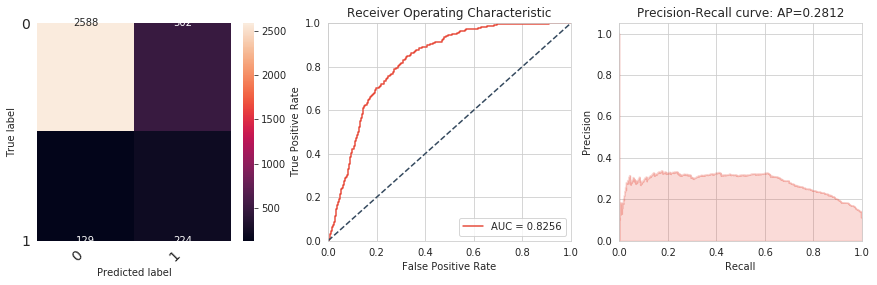

AttributeError: ignored

<Figure size 1008x720 with 0 Axes>

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

Logistic Regression- last 200 words

In [0]:
model= LogisticRegression(C=0.001,penalty='l2')
model.fit(X_train.values, y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = get_predictions(model, test = X_test.values)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.87      0.91      3090
           1       0.39      0.74      0.51       353

    accuracy                           0.85      3443
   macro avg       0.68      0.80      0.71      3443
weighted avg       0.91      0.85      0.87      3443


F1 Score: 0.51
Recall: 0.74
Precision: 0.39
Accuracy: 0.85
Brier Score: 0.15


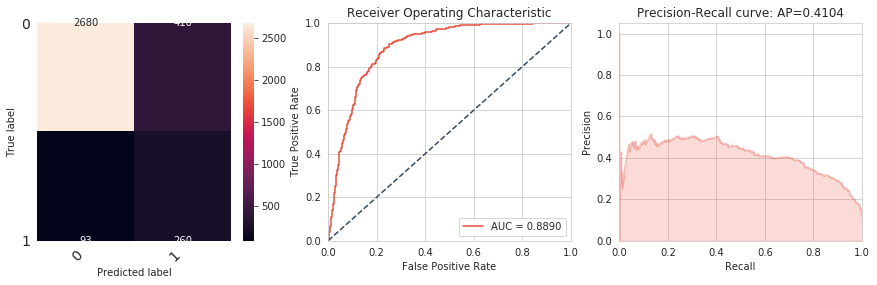

AttributeError: ignored

<Figure size 1008x720 with 0 Axes>

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

### Only ngram and tfidf

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

In [0]:
y_test1 = pd.read_pickle(os.path.join(data_location,'y_test (1).pkl'))
y_train1 = pd.read_pickle(os.path.join(data_location,'y_train (1).pkl'))

In [0]:
len(y_test1)

3436

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
vectorizer = CountVectorizer(stop_words="english")
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])


In [0]:
y_test=y_test1['label'].astype(int)
y_train=y_train1['label'].astype(int)

In [0]:
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = get_predictions(model, test = test_features)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3083
           1       0.72      0.76      0.74       353

    accuracy                           0.94      3436
   macro avg       0.85      0.86      0.85      3436
weighted avg       0.95      0.94      0.95      3436


F1 Score: 0.74
Recall: 0.76
Precision: 0.72
Accuracy: 0.94
Brier Score: 0.06


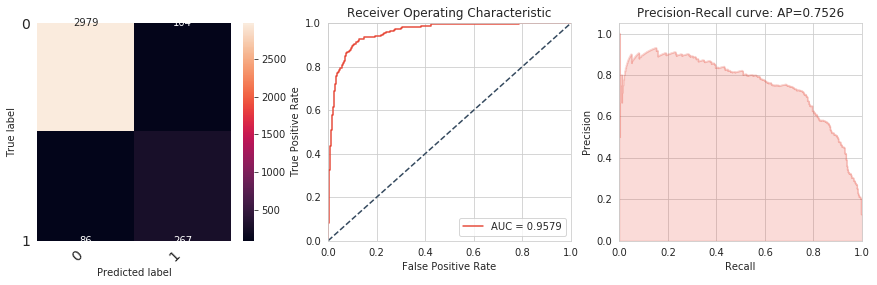

<Figure size 1008x720 with 0 Axes>

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

64 words

In [0]:
vectorizer = CountVectorizer(stop_words="english")

In [0]:
X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:64])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:64])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3083
           1       0.42      0.64      0.51       353

    accuracy                           0.87      3436
   macro avg       0.69      0.77      0.72      3436
weighted avg       0.90      0.87      0.88      3436


F1 Score: 0.51
Recall: 0.64
Precision: 0.42
Accuracy: 0.87
Brier Score: 0.13


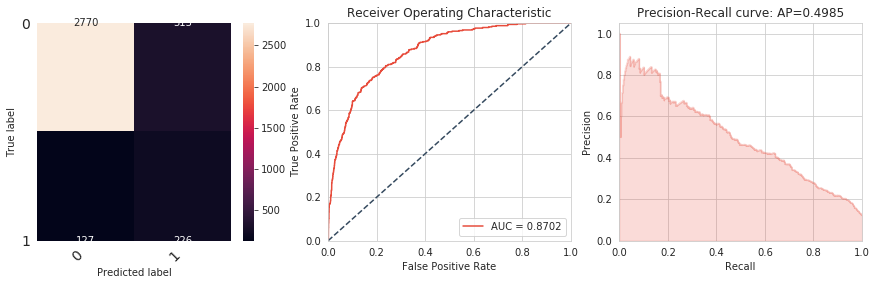

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2770,  313],
       [ 127,  226]])

128 words

In [0]:
vectorizer = CountVectorizer(stop_words="english")

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

In [0]:
X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:128])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:128])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3083
           1       0.58      0.52      0.55       353

    accuracy                           0.91      3436
   macro avg       0.76      0.74      0.75      3436
weighted avg       0.91      0.91      0.91      3436


F1 Score: 0.55
Recall: 0.52
Precision: 0.58
Accuracy: 0.91
Brier Score: 0.09


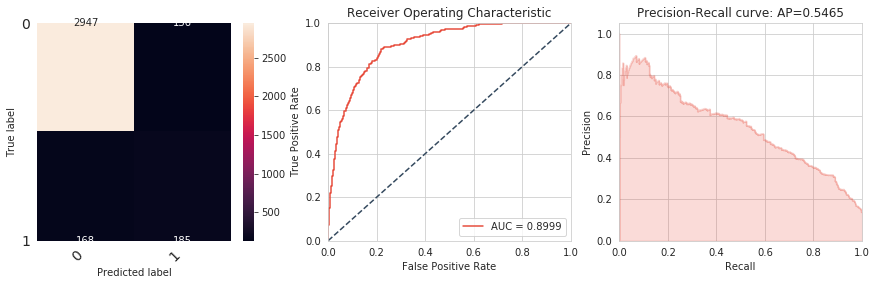

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2947,  136],
       [ 168,  185]])

256 words

In [0]:
vectorizer = CountVectorizer(stop_words="english")

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:256])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:256])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3083
           1       0.54      0.71      0.61       353

    accuracy                           0.91      3436
   macro avg       0.75      0.82      0.78      3436
weighted avg       0.92      0.91      0.91      3436


F1 Score: 0.61
Recall: 0.71
Precision: 0.54
Accuracy: 0.91
Brier Score: 0.09


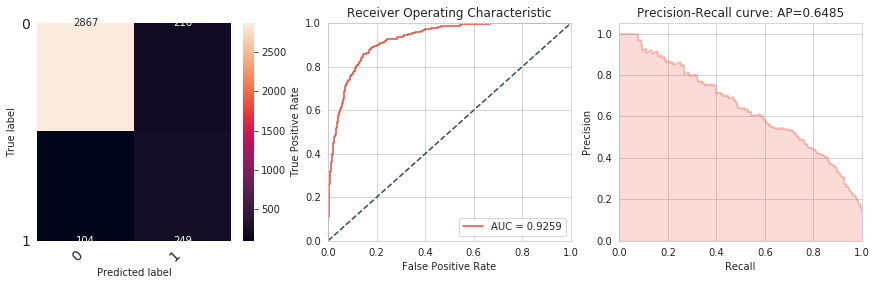

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2867,  216],
       [ 104,  249]])

512 words

In [0]:
vectorizer = CountVectorizer(stop_words="english")

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:512])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:512])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3083
           1       0.64      0.74      0.69       353

    accuracy                           0.93      3436
   macro avg       0.81      0.85      0.82      3436
weighted avg       0.94      0.93      0.93      3436


F1 Score: 0.69
Recall: 0.74
Precision: 0.64
Accuracy: 0.93
Brier Score: 0.07


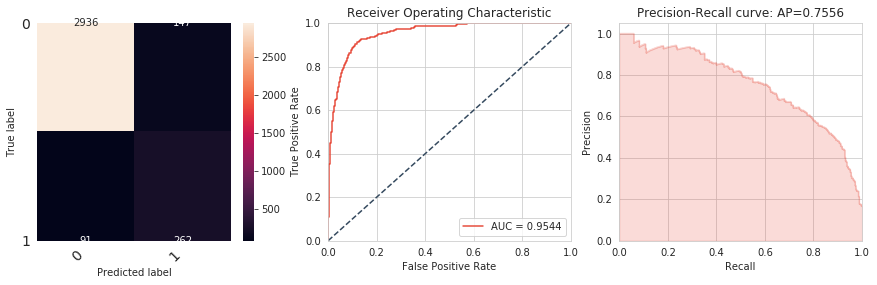

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2936,  147],
       [  91,  262]])

Tf-idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
y_test=y_test1['label'].astype(int)
y_train=y_train1['label'].astype(int)

In [0]:
model= LogisticRegression(C=10,penalty='l2')
model.fit(training_features, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
preds = get_predictions(model, test = test_features)

In [0]:
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)

In [0]:
y_pred = (preds>=best_cutoff).astype(int)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3083
           1       0.76      0.76      0.76       353

    accuracy                           0.95      3436
   macro avg       0.87      0.86      0.86      3436
weighted avg       0.95      0.95      0.95      3436


F1 Score: 0.76
Recall: 0.76
Precision: 0.76
Accuracy: 0.95
Brier Score: 0.05


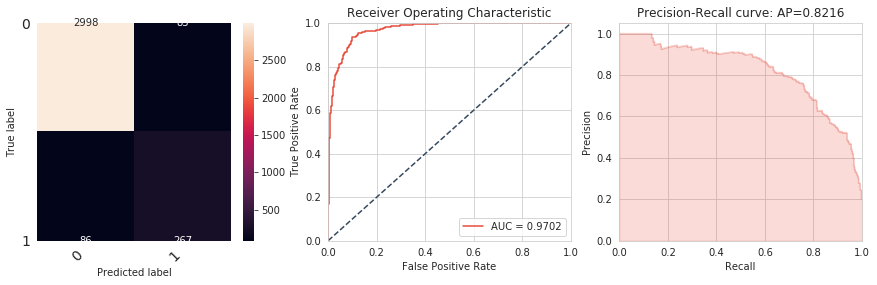

<Figure size 1008x720 with 0 Axes>

In [0]:
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

Word limit- 64

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

In [0]:
X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:64])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:64])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
X_train1.loc[0,'article_text']

"News flash: There's a crisis at the border. This was discovered again over the past few days when immigration attorneys talked to reporters about appalling conditions at a Border Patrol facility detaining migrant minors in Clint, Texas. According to the lawyers, many of the kids had to sleep on the concrete floor, failed to get proper adult supervision and didn't routinely take showers or"

In [0]:
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3083
           1       0.47      0.71      0.56       353

    accuracy                           0.89      3436
   macro avg       0.72      0.81      0.75      3436
weighted avg       0.91      0.89      0.90      3436


F1 Score: 0.56
Recall: 0.71
Precision: 0.47
Accuracy: 0.89
Brier Score: 0.11


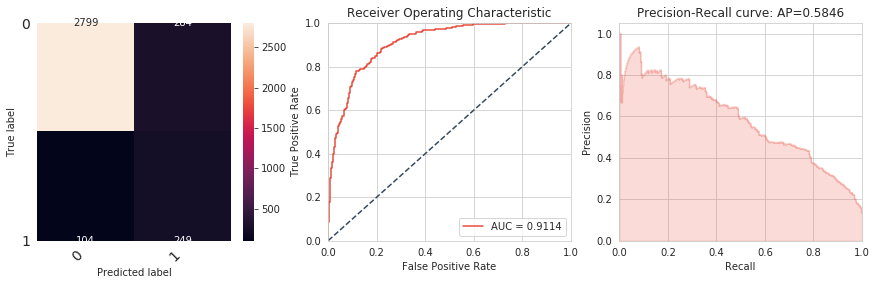

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2799,  284],
       [ 104,  249]])

Decision Tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
model=DecisionTreeClassifier(max_depth=5)
model.fit(training_features, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      3083
           1       0.41      0.21      0.28       353

    accuracy                           0.89      3436
   macro avg       0.66      0.59      0.61      3436
weighted avg       0.86      0.89      0.87      3436


F1 Score: 0.28
Recall: 0.21
Precision: 0.41
Accuracy: 0.89
Brier Score: 0.11


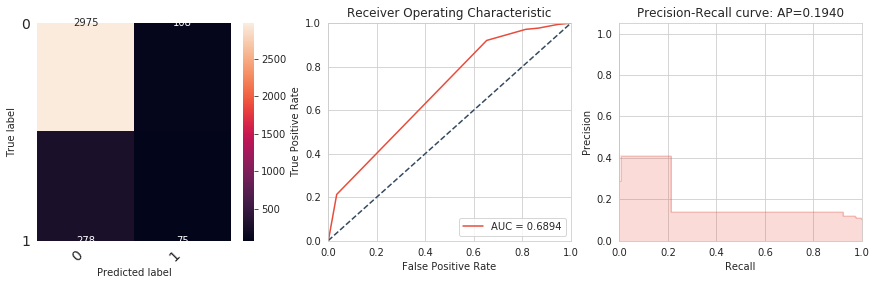

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2975,  108],
       [ 278,   75]])

Random Forest


In [0]:
#model = joblib.load(model_location)
model= RandomForestClassifier(n_estimators=250, max_depth=15)
model.fit(training_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3083
           1       0.44      0.54      0.49       353

    accuracy                           0.88      3436
   macro avg       0.69      0.73      0.71      3436
weighted avg       0.89      0.88      0.89      3436


F1 Score: 0.49
Recall: 0.54
Precision: 0.44
Accuracy: 0.88
Brier Score: 0.12


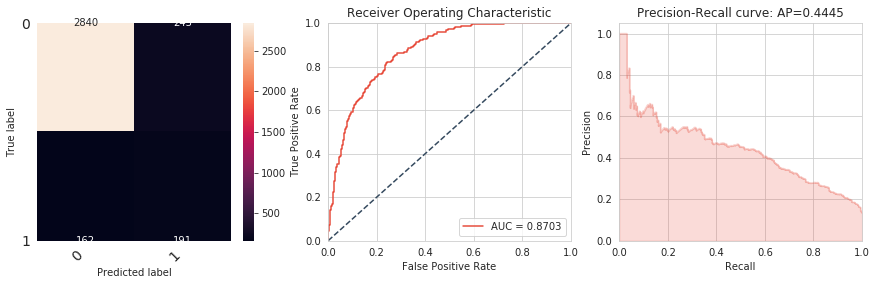

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2840,  243],
       [ 162,  191]])

Gradient Boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier
model= GradientBoostingClassifier(n_estimators=120)

In [0]:
model.fit(training_features, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3083
           1       0.46      0.52      0.49       353

    accuracy                           0.89      3436
   macro avg       0.70      0.73      0.71      3436
weighted avg       0.89      0.89      0.89      3436


F1 Score: 0.49
Recall: 0.52
Precision: 0.46
Accuracy: 0.89
Brier Score: 0.11


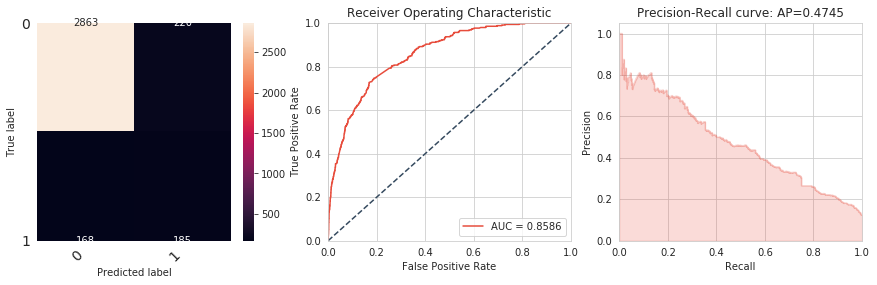

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2863,  220],
       [ 168,  185]])

128 words

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:128])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:128])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3083
           1       0.61      0.58      0.60       353

    accuracy                           0.92      3436
   macro avg       0.78      0.77      0.78      3436
weighted avg       0.92      0.92      0.92      3436


F1 Score: 0.60
Recall: 0.58
Precision: 0.61
Accuracy: 0.92
Brier Score: 0.08


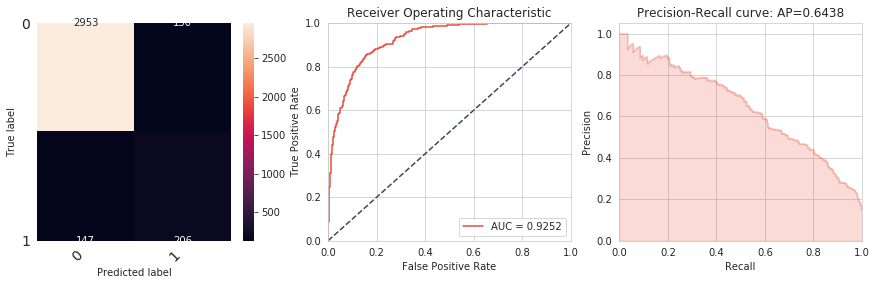

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2953,  130],
       [ 147,  206]])

Decision Tree


In [0]:
model=DecisionTreeClassifier(max_depth=3)
model.fit(training_features, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3083
           1       0.34      0.37      0.35       353

    accuracy                           0.86      3436
   macro avg       0.63      0.64      0.64      3436
weighted avg       0.87      0.86      0.86      3436


F1 Score: 0.35
Recall: 0.37
Precision: 0.34
Accuracy: 0.86
Brier Score: 0.14


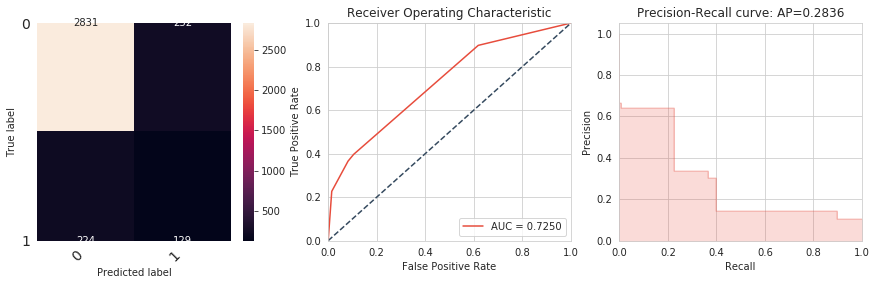

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2831,  252],
       [ 224,  129]])

Random Forest

In [0]:
#model = joblib.load(model_location)
model= RandomForestClassifier(n_estimators=250, max_depth=15)
model.fit(training_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3083
           1       0.43      0.61      0.50       353

    accuracy                           0.88      3436
   macro avg       0.69      0.76      0.71      3436
weighted avg       0.90      0.88      0.88      3436


F1 Score: 0.50
Recall: 0.61
Precision: 0.43
Accuracy: 0.88
Brier Score: 0.12


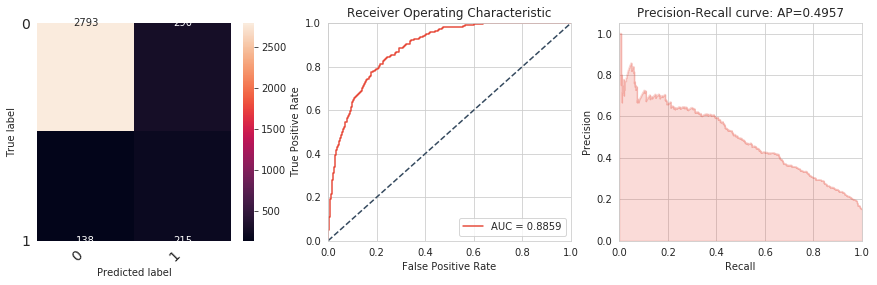

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2793,  290],
       [ 138,  215]])

Gradient Boosting

In [0]:
model= GradientBoostingClassifier(n_estimators=120)
model.fit(training_features, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3083
           1       0.52      0.52      0.52       353

    accuracy                           0.90      3436
   macro avg       0.73      0.73      0.73      3436
weighted avg       0.90      0.90      0.90      3436


F1 Score: 0.52
Recall: 0.52
Precision: 0.52
Accuracy: 0.90
Brier Score: 0.10


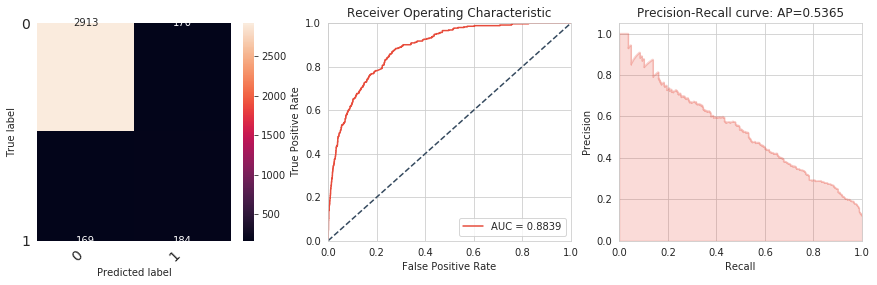

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2913,  170],
       [ 169,  184]])

256 words

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:256])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:256])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3083
           1       0.60      0.71      0.65       353

    accuracy                           0.92      3436
   macro avg       0.78      0.83      0.80      3436
weighted avg       0.93      0.92      0.92      3436


F1 Score: 0.65
Recall: 0.71
Precision: 0.60
Accuracy: 0.92
Brier Score: 0.08


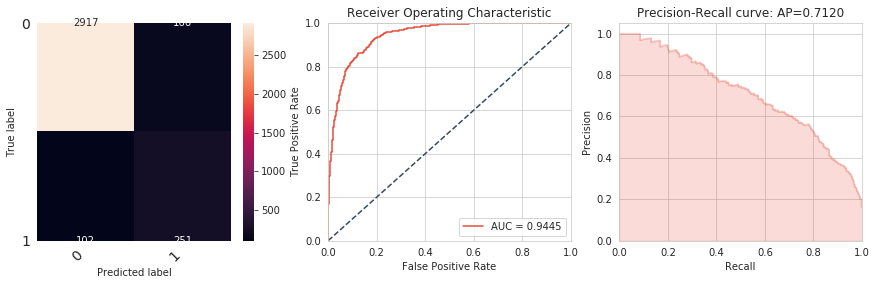

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2917,  166],
       [ 102,  251]])

Decison Tree

In [0]:
model=DecisionTreeClassifier(max_depth=5)
model.fit(training_features, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3083
           1       0.40      0.50      0.44       353

    accuracy                           0.87      3436
   macro avg       0.67      0.71      0.69      3436
weighted avg       0.89      0.87      0.88      3436


F1 Score: 0.44
Recall: 0.50
Precision: 0.40
Accuracy: 0.87
Brier Score: 0.13


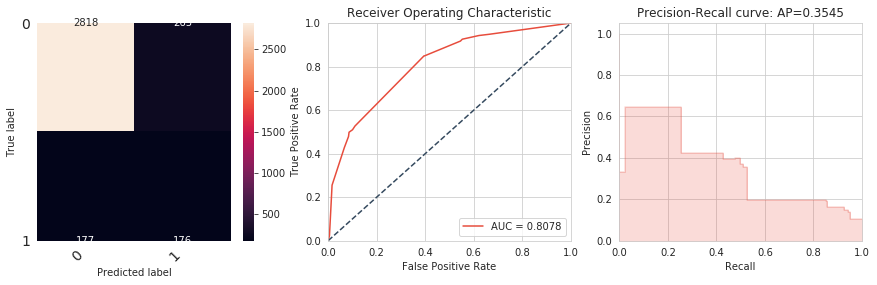

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2818,  265],
       [ 177,  176]])

Random Forest

In [0]:
#model = joblib.load(model_location)
model= RandomForestClassifier(n_estimators=250, max_depth=15)
model.fit(training_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3083
           1       0.54      0.53      0.53       353

    accuracy                           0.90      3436
   macro avg       0.74      0.74      0.74      3436
weighted avg       0.90      0.90      0.90      3436


F1 Score: 0.53
Recall: 0.53
Precision: 0.54
Accuracy: 0.90
Brier Score: 0.10


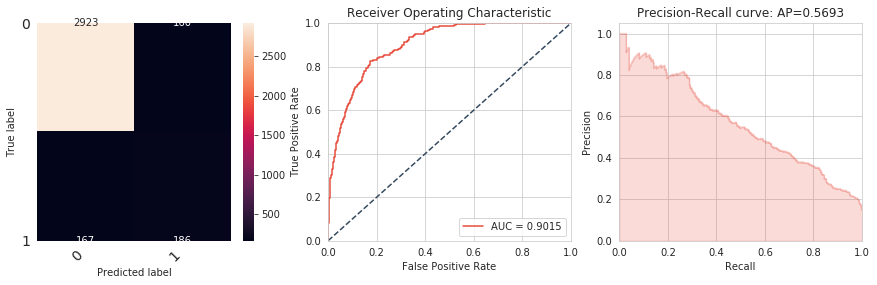

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2923,  160],
       [ 167,  186]])

Gradient Boosting

In [0]:
model= GradientBoostingClassifier(n_estimators=120)
model.fit(training_features, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3083
           1       0.57      0.60      0.58       353

    accuracy                           0.91      3436
   macro avg       0.76      0.77      0.77      3436
weighted avg       0.91      0.91      0.91      3436


F1 Score: 0.58
Recall: 0.60
Precision: 0.57
Accuracy: 0.91
Brier Score: 0.09


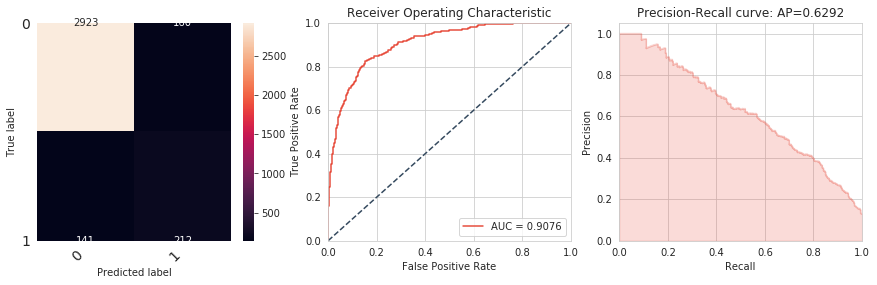

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2923,  160],
       [ 141,  212]])

512 words

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:512])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:512])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3083
           1       0.69      0.74      0.72       353

    accuracy                           0.94      3436
   macro avg       0.83      0.85      0.84      3436
weighted avg       0.94      0.94      0.94      3436


F1 Score: 0.72
Recall: 0.74
Precision: 0.69
Accuracy: 0.94
Brier Score: 0.06


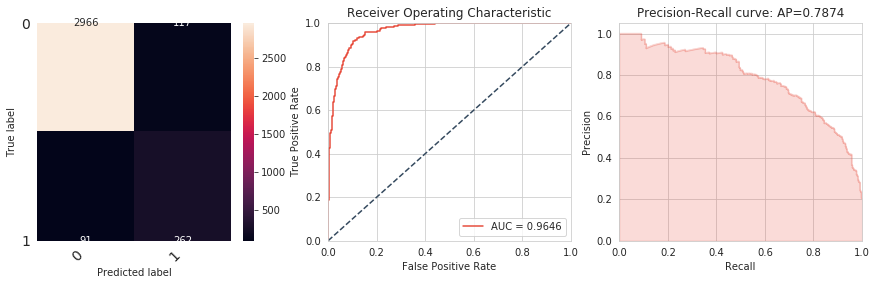

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2966,  117],
       [  91,  262]])

Decison Tree


In [0]:
model=DecisionTreeClassifier(max_depth=3)
model.fit(training_features, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3083
           1       0.44      0.56      0.49       353

    accuracy                           0.88      3436
   macro avg       0.69      0.74      0.71      3436
weighted avg       0.90      0.88      0.89      3436


F1 Score: 0.49
Recall: 0.56
Precision: 0.44
Accuracy: 0.88
Brier Score: 0.12


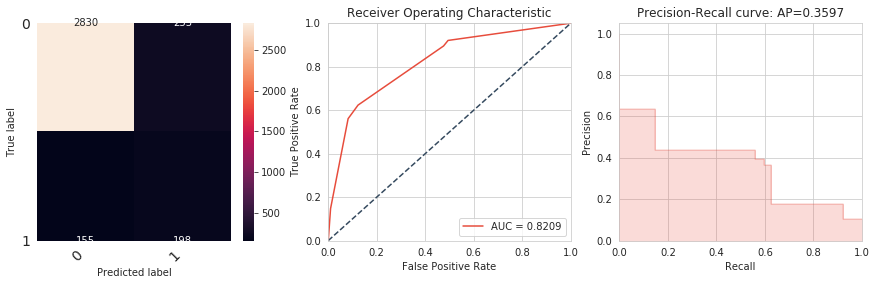

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2830,  253],
       [ 155,  198]])

Random Forest

In [0]:
#model = joblib.load(model_location)
model= RandomForestClassifier(n_estimators=250, max_depth=15)
model.fit(training_features, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      3083
           1       0.55      0.60      0.58       353

    accuracy                           0.91      3436
   macro avg       0.75      0.77      0.76      3436
weighted avg       0.91      0.91      0.91      3436


F1 Score: 0.58
Recall: 0.60
Precision: 0.55
Accuracy: 0.91
Brier Score: 0.09


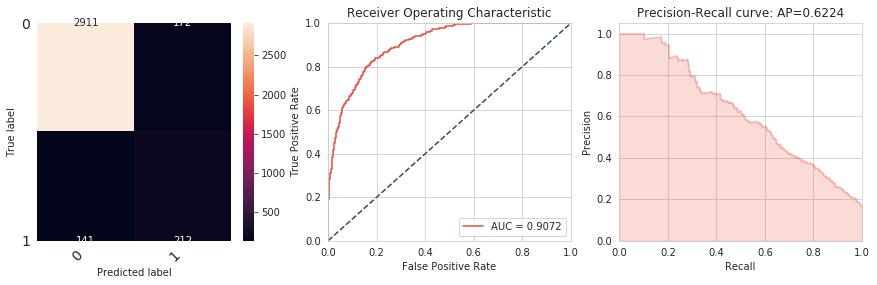

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2911,  172],
       [ 141,  212]])

Gradient Boosting

In [0]:
model= GradientBoostingClassifier(n_estimators=120)
model.fit(training_features, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=120,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      3083
           1       0.61      0.71      0.66       353

    accuracy                           0.92      3436
   macro avg       0.79      0.83      0.81      3436
weighted avg       0.93      0.92      0.93      3436


F1 Score: 0.66
Recall: 0.71
Precision: 0.61
Accuracy: 0.92
Brier Score: 0.08


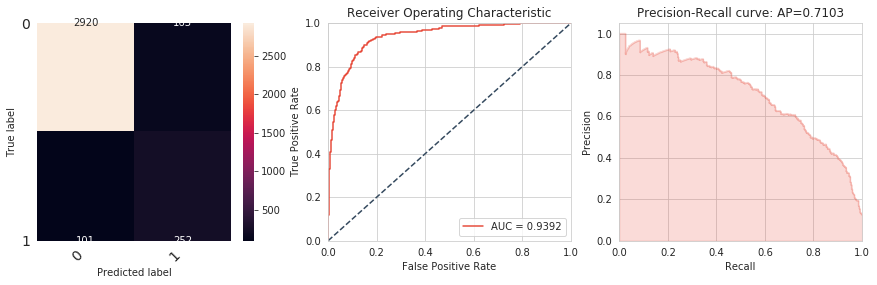

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)

array([[2920,  163],
       [ 101,  252]])

First 200 words- tfidf

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:200])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:200])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      3083
           1       0.56      0.73      0.63       353

    accuracy                           0.91      3436
   macro avg       0.76      0.83      0.79      3436
weighted avg       0.93      0.91      0.92      3436


F1 Score: 0.63
Recall: 0.73
Precision: 0.56
Accuracy: 0.91
Brier Score: 0.09


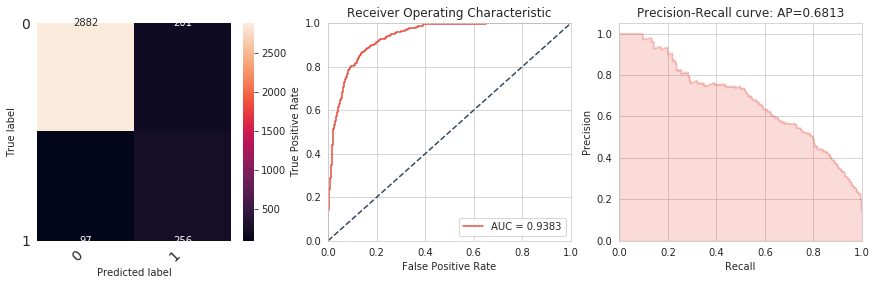

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2882,  201],
       [  97,  256]])

Last 200 words- tfidf

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[-200:])
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[-200:])
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [0]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3083
           1       0.72      0.71      0.71       353

    accuracy                           0.94      3436
   macro avg       0.84      0.84      0.84      3436
weighted avg       0.94      0.94      0.94      3436


F1 Score: 0.71
Recall: 0.71
Precision: 0.72
Accuracy: 0.94
Brier Score: 0.06


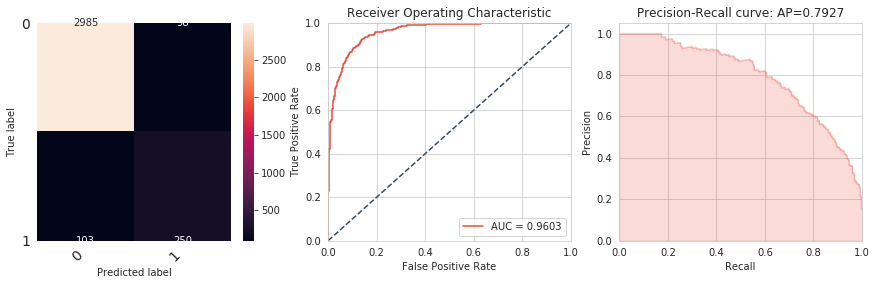

<Figure size 1008x720 with 0 Axes>

In [0]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test,y_pred)

array([[2985,   98],
       [ 103,  250]])

Heading + first 200 words + last 200 words

In [0]:
X_test1 = pd.read_pickle(os.path.join(data_location,'X_test.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

In [18]:
X_train1.columns

Index(['source_name', 'url', 'created_date', 'tag', 'heading', 'author',
       'article_text', 'preprocessed_text', 'avg_word_length', 'neg_vader',
       'neu_vader', 'pos_vader', 'compound_vader', 'afinn', 'article_length',
       'heading_length', 'num_questions', 'num_exclamations',
       'article_sentiment', 'article_subjectivity', 'heading_sentiment',
       'heading_subjectivity', 'ENT_PERSON', 'ENT_NORP', 'ENT_ORG',
       'ENT_LOCATION', 'ENT_PRODUCT', 'ENT_LANGUAGE', 'ENT_OTHERS', 'POS_ADJ',
       'POS_ADV', 'POS_PROPN', 'POS_NUM', 'POS_AUX'],
      dtype='object')

In [0]:

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:200] + x.split()[-200:] if len(x.split())>400 else x.split())
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))
X_train1['article_text']=X_train1['heading'] + X_train1['article_text']

X_test1['article_text']=X_test1['article_text'].apply(lambda x: x.split()[:200] + x.split()[-200:] if len(x.split())>400 else x.split())
X_test1['article_text']=X_test1['article_text'].apply(lambda x: ' '.join(x))
X_test1['article_text']=X_test1['heading'] + X_test1['article_text']


In [20]:
X_train1.loc[0,'article_text']

"Lowry: What a border crisis looks likeNews flash: There's a crisis at the border. This was discovered again over the past few days when immigration attorneys talked to reporters about appalling conditions at a Border Patrol facility detaining migrant minors in Clint, Texas. According to the lawyers, many of the kids had to sleep on the concrete floor, failed to get proper adult supervision and didn't routinely take showers or brush their teeth. The details were hard to read. Assuming the account was accurate, one wonders how we could treat anyone this way, let alone children? But a lawyer who talked to The New Yorker mentioned a telling fact: The facility previously had a capacity of 104 and had never held children before. Yet it held roughly 350 children, apparently accommodated by placement of a new warehouse at the site. All this is consistent with vast numbers of migrants, many of them families and children, flooding the border and overtaxing facilities never meant for these kinds

In [0]:
y_test1 = pd.read_pickle(os.path.join(data_location,'y_test (1).pkl'))
y_train1 = pd.read_pickle(os.path.join(data_location,'y_train (1).pkl'))

y_train=y_train1['label'].astype(int)
y_test=y_test1['label'].astype(int)

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])

In [13]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3083
           1       0.82      0.77      0.79       353

    accuracy                           0.96      3436
   macro avg       0.90      0.88      0.89      3436
weighted avg       0.96      0.96      0.96      3436


F1 Score: 0.79
Recall: 0.77
Precision: 0.82
Accuracy: 0.96
Brier Score: 0.04


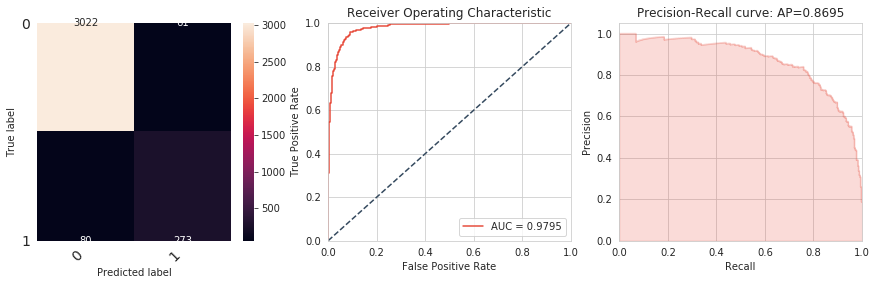

<Figure size 1008x720 with 0 Axes>

In [14]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [15]:
confusion_matrix(y_test,y_pred)

array([[3022,   61],
       [  80,  273]])

Count vectorizer

In [0]:
vectorizer = CountVectorizer(stop_words="english")
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(X_test1["article_text"])


In [23]:
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3083
           1       0.75      0.87      0.81       353

    accuracy                           0.96      3436
   macro avg       0.87      0.92      0.89      3436
weighted avg       0.96      0.96      0.96      3436


F1 Score: 0.81
Recall: 0.87
Precision: 0.75
Accuracy: 0.96
Brier Score: 0.04


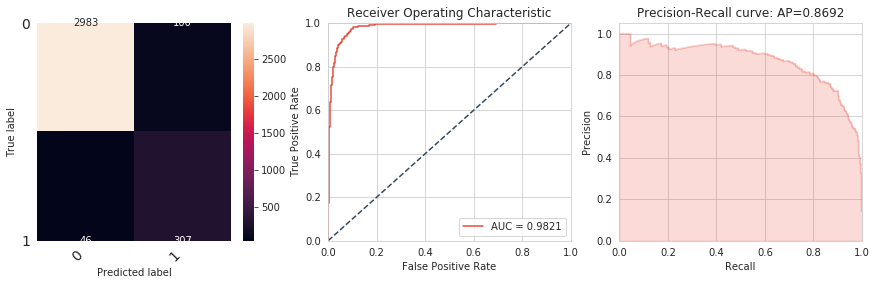

<Figure size 1008x720 with 0 Axes>

In [24]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [25]:
confusion_matrix(y_test, y_pred)

array([[2983,  100],
       [  46,  307]])

Testing on unseen data- feature importances and weight

In [0]:
metro_winnipeg = pd.read_pickle(os.path.join(data_location,'metro_winnipeg.pkl'))
X_train1 = pd.read_pickle(os.path.join(data_location,'X_train.pkl'))

In [40]:
metro_winnipeg.head()

,URL,date,title,content,tag,Editorial,author
0,https://winnipegsun.com/entertainment/televisi...,2019-03-31,‘KUWTK’ tops this week’s TV must-sees,Keeping Up with the Kardashians Season Premier...,"hbo canada, keeping up with the kardashians, n...",regular,"Samantha O'Connor, Special to Postmedia"
1,https://winnipegsun.com/opinion/editorials/edi...,2019-03-31,EDITORIAL: Yet again we mourn,"New Zealand is half a world away, but the rece...","canada, editorial, terrorism",editorial,Winnipeg Sun
2,https://winnipegsun.com/opinion/letters/letter...,2019-03-31,"Letters: March 31, 2019",This stinks A stench has been emanating from t...,"government of canada, justin trudeau, letters ...",other,Winnipeg Sun readers
3,https://winnipegsun.com/entertainment/celebrit...,2019-03-31,‘I’M A HUSTLER BABY’: Jennifer Lopez shows off...,Jennifer Lopez is on the set of her upcoming m...,"alex rodriguez, jennifer lopez",regular,American Media Inc.
4,https://winnipegsun.com/entertainment/celebrit...,2019-04-01,Bob Dylan’s paintings to be exhibited at Tulsa...,"TULSA, Okla. — A Tulsa museum will soon open a...","arts, bob dylan, museums, oklahoma, painting",regular,Associated Press


In [0]:
metro_winnipeg['article_length']=metro_winnipeg['content'].apply(lambda x: len(x.split()))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa7f54336d8>]],
      dtype=object)

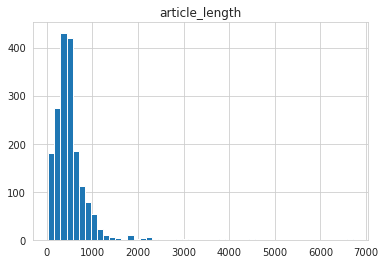

In [42]:
metro_winnipeg.hist(column='article_length',bins=50)

In [0]:
metro_winnipeg['Editorial']=metro_winnipeg['Editorial'].apply(lambda x: 1 if x=='editorial' else 0)

In [44]:
metro_winnipeg['Editorial'].value_counts()

0    1657
1     148
Name: Editorial, dtype: int64

In [0]:

X_train1['article_text']=X_train1['article_text'].apply(lambda x: x.split()[:200] + x.split()[-200:] if len(x.split())>400 else x.split())
X_train1['article_text']=X_train1['article_text'].apply(lambda x: ' '.join(x))
X_train1['article_text']=X_train1['heading'] + X_train1['article_text']

metro_winnipeg['content']=metro_winnipeg['content'].apply(lambda x: x.split()[:200] + x.split()[-200:] if len(x.split())>400 else x.split())
metro_winnipeg['content']=metro_winnipeg['content'].apply(lambda x: ' '.join(x))
metro_winnipeg['content']=metro_winnipeg['title'] + metro_winnipeg['content']


In [0]:
#y_test1 = pd.read_pickle(os.path.join(data_location,'y_test (1).pkl'))
y_train1 = pd.read_pickle(os.path.join(data_location,'y_train (1).pkl'))

y_train=y_train1['label'].astype(int)
y_test=metro_winnipeg['Editorial'].astype(int)

In [47]:
metro_winnipeg.loc[0,'content']

'‘KUWTK’ tops this week’s TV must-sees Keeping Up with the Kardashians Season Premiere In the Season 16 premiere of the long-running reality show, Kourtney and her sisters plan a girls trip to Palm Springs after a breakup triggers incredible anxiety. When: Sunday on E! Our Planet Miniseries It’s not a nature documentary without the voice of BBC’s David Attenborough, who narrates this latest wildlife miniseries. Filmed in 4K video over a four-year period and across seven continents, the new series hopes to draw attention to climate change. When: Friday on Netflix Veep Season 7 debut The seventh and final season of the political comedy premieres as Julia Louis-Dreyfus returns as former VP Selina, who evaluates her past and present campaigns with the hopes of eventually making it back to the Oval Office. When: Sunday on HBO Canada Unicorn Store Movie Captain Marvel’s Brie Larson directs and stars in this whimsical comedy about a young woman who is determined to fulfil her childhood dream 

In [0]:
vectorizer = CountVectorizer(stop_words="english")
training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(metro_winnipeg["content"])


In [36]:
model= LogisticRegression(C=0.1,penalty='l1')
model.fit(training_features, y_train)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1657
           1       0.76      0.84      0.79       148

    accuracy                           0.96      1805
   macro avg       0.87      0.91      0.89      1805
weighted avg       0.97      0.96      0.97      1805


F1 Score: 0.79
Recall: 0.84
Precision: 0.76
Accuracy: 0.96
Brier Score: 0.04


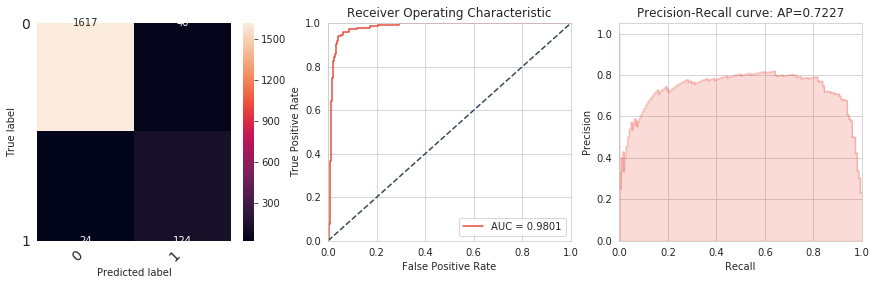

<Figure size 1008x720 with 0 Axes>

In [37]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [38]:
confusion_matrix(y_test, y_pred)

array([[1617,   40],
       [  24,  124]])

Tfidf to predict on unseen data

In [0]:
vectorizer = TfidfVectorizer(stop_words="english",
                             ngram_range=(1, 2))

training_features = vectorizer.fit_transform(X_train1["article_text"])    
test_features = vectorizer.transform(metro_winnipeg["content"])

In [49]:
model= LogisticRegression(C=100,penalty='l2')
model.fit(training_features, y_train)


LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1657
           1       0.34      0.90      0.50       148

    accuracy                           0.85      1805
   macro avg       0.67      0.87      0.70      1805
weighted avg       0.94      0.85      0.88      1805


F1 Score: 0.50
Recall: 0.90
Precision: 0.34
Accuracy: 0.85
Brier Score: 0.15


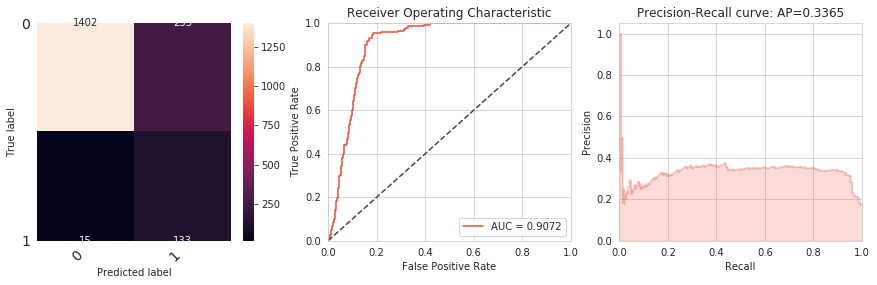

<Figure size 1008x720 with 0 Axes>

In [50]:
preds = get_predictions(model, test = test_features)
best_cutoff = find_cutoff(ground_truth=y_test.values, predictions= preds, metric = f1_score)
y_pred = (preds>=best_cutoff).astype(int)
ml_report(model = model, y_true=y_test.values, predictions=preds, cutoff = best_cutoff)

In [0]:
confusion_matrix(y_test, y_pred)